In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sqlite3 as db
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from nanoGPT.model import GPT, GPTConfig
from lightning_training import *

from data_process.tokenizers import FullMoveTokenizer

In [3]:
elite_database = db.connect("./data/lichess_elite_database.db")

In [4]:
games_df = pd.read_sql("SELECT * FROM games", elite_database)

In [5]:
games_df

,pgn,piece_uci
0,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pe7e5 Ng1f3 Nb8c6 Bf1c4 Bf8c5 Ke1g1 Pd7d...
1,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pd7d5 Nb1c3 Pd5e4 Nc3e4 Qd8d5 Qd1f3 Nb8c...
2,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pc7c5 Pc2c3 Ng8f6 Pe4e5 Nf6d5 Ng1f3 Nb8c...
3,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5a5 Pd2d4 Pc7c...
4,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pc2c4 Pe7e6 Pg2g3 Pd7d5 Bf1g2 Ng8f6 Ng1f3 Bf8e...
...,...,...
3819125,"[Event ""Rated Classical game""]\n[Date ""????.??...",Pe2e4 Pc7c5 Ng1f3 Pg7g6 Nb1c3 Bf8g7 Pd2d4 Pc5d...
3819126,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pc2c4 Ng8f6 Nb1c3 Pg7g6 Pe2e4 Bf8g7 Pd2d4 Pd7d...
3819127,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pd2d4 Ng8f6 Pc2c4 Pd7d6 Nb1c3 Pe7e5 Pe2e4 Nb8d...
3819128,"[Event ""Rated Blitz game""]\n[Date ""????.??.??""...",Pd2d4 Ng8f6 Ng1f3 Pd7d6 Pc2c4 Pg7g6 Nb1c3 Bf8g...


In [5]:
tokenizer = FullMoveTokenizer()

In [6]:
games = list(games_df.piece_uci)

In [27]:
lengths = [len(game.split()) for game in games]

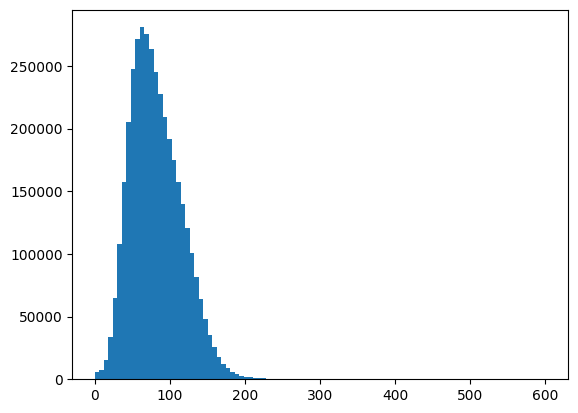

In [28]:
plt.hist(lengths, bins=100)
plt.show()

In [7]:
data_module = GamesDataModule(games)

In [8]:
model_config = GPTConfig(
    block_size=301,
    vocab_size=len(tokenizer.vocab),
    n_layer=3,
    n_head=4,
    n_embd=256,
    bias=False,
)

pl_model = LightningGPT(model_config)

number of parameters: 3.41M


In [9]:
data_module.num_workers = 14

In [23]:
tensorboard_logger = pl.loggers.TensorBoardLogger(save_dir="./lightning_logs", name=f"test_v2")

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=2,
    callbacks=[pl.callbacks.RichProgressBar()],
    logger=tensorboard_logger,
    profiler="pytorch",
    # default_root_dir=
    # fast_dev_run=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(
    model=pl_model,
    datamodule=data_module,
    # ckpt_path="../../lightning_logs/sentimate/SentimateNet/version_0/checkpoints/epoch=49-step=536050.ckpt"
    # ckpt_path="../../lightning_logs/sentimate/tensorboard/SentimateNet/version_1/checkpoints/epoch=29-step=321630.ckpt"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ GPT                │  3.5 M │
│ 1 │ test_accuracy │ MulticlassAccuracy │      0 │
└───┴───────────────┴────────────────────┴────────┘

Trainable params: 3.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.5 M                                                                                                
Total estimated model params size (MB): 13

Output()

STAGE:2024-04-01 18:31:36 10057:10057 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-01 18:31:46 10057:10057 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-01 18:31:46 10057:10057 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#AdamW.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]LightningGPT.optimizer_step (function operator())


/home/kamil/miniconda3/envs/pytorch/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected 
KeyboardInterrupt, attempting graceful shutdown...

In [27]:
checkpoint_path = './lightning_logs/test_v2/version_1/checkpoints/epoch=0-step=53704.ckpt'

checkpoint = torch.load(checkpoint_path)

In [33]:
pl_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [72]:
pl_model.cpu()

output = pl_model.model.generate(torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long), max_new_tokens=80, top_k=1)

In [73]:
generated_game = tokenizer.decode(output[0].tolist())

In [74]:
generated_game

'Pd2d4 Ng8f6 Pc2c4 Pe7e6 Nb1c3 Bf8b4 Pe2e3 Ke8g8 Ng1e2 Pd7d5 Pa2a3 Bb4e7 Pc4d5 Pe6d5 Ne2g3 Pc7c6 Bf1d3 Rf8e8 Ke1g1 Nb8d7 Pf2f3 Nd7f8 Pe3e4 Pd5e4 Pf3e4 Bc8g4 Bd3e2 Bg4e2 Qd1e2 Nf8e6 Bc1e3 Ne6d4 Be3d4 Qd8d4 Kg1h1 Ra8d8 Ra1d1 Qd4b6 Pe4e5 Nf6d5 Nc3d5 Pc6d5 Ng3f5 Be7f8 Qe2g4 Qb6e6 Nf5d4 Qe6e5 Nd4f3 Qe5e4 Qg4h5 Pg7g6 Qh5h6 Bf8g7 Qh6h4 Qe4e6 Nf3g5 Qe6f6 Rf1f6 Bg7f6 Qh4h7 Kg8f8 Rd1f1 Kf8e7 Qh7f7 Ke7d6 Qf7f6 Kd6c7 Qf6f7 Kc7b6 Qf7f6 Rd8d7 Ph2h3 Pd5d4 Kh1h2 Pd4d3 Rf1d1 Pd3d2 Rd1d2 Rd7d2'

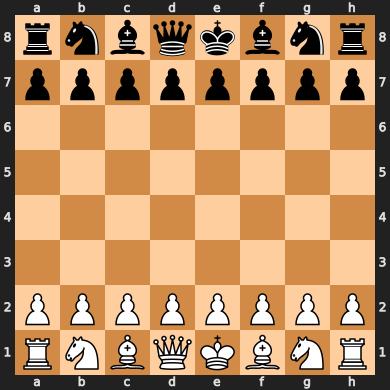

Pd2d4


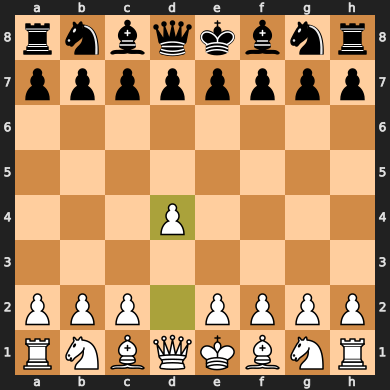

Ng8f6


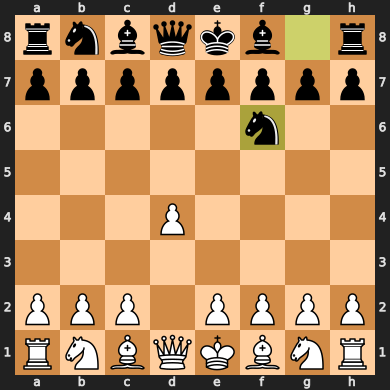

Pc2c4


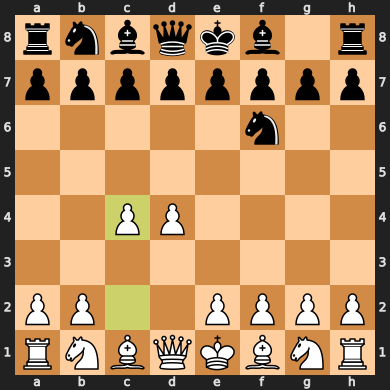

Pe7e6


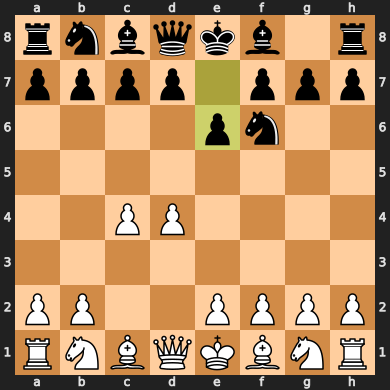

Nb1c3


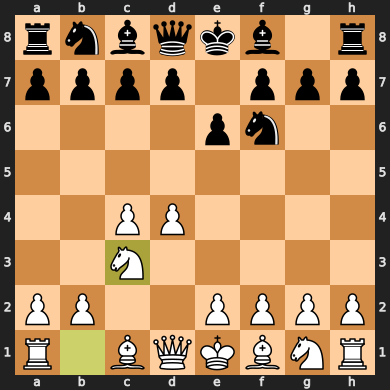

Bf8b4


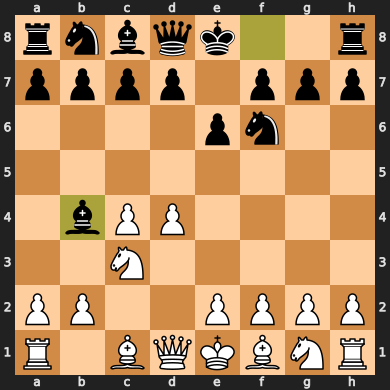

Pe2e3


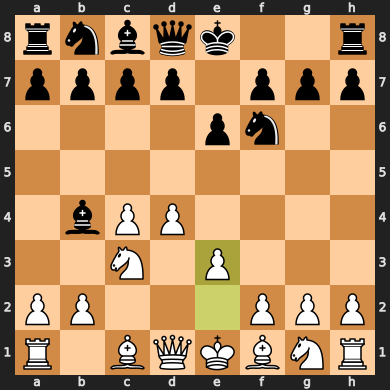

Ke8g8


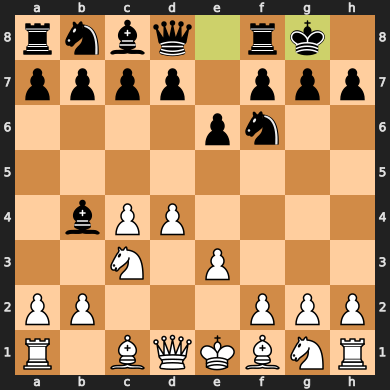

Ng1e2


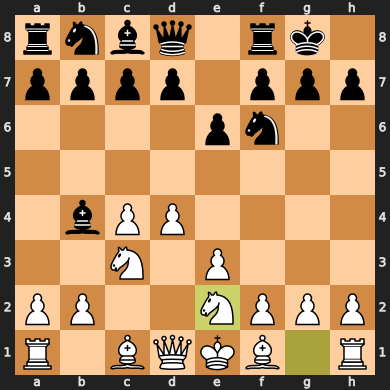

Pd7d5


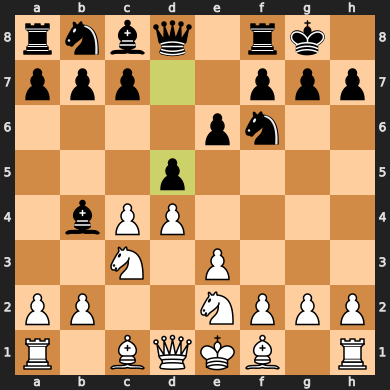

Pa2a3


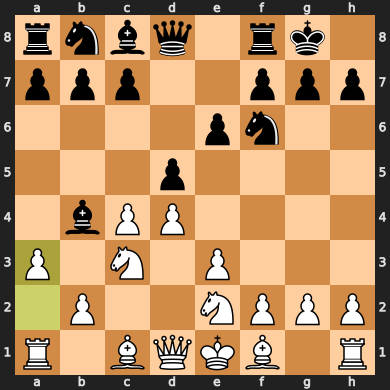

Bb4e7


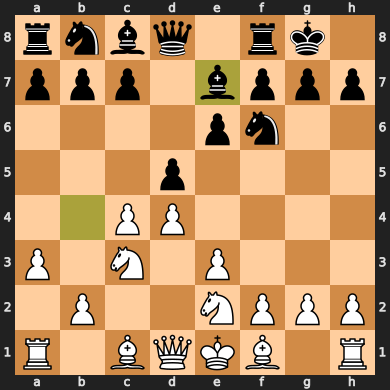

Pc4d5


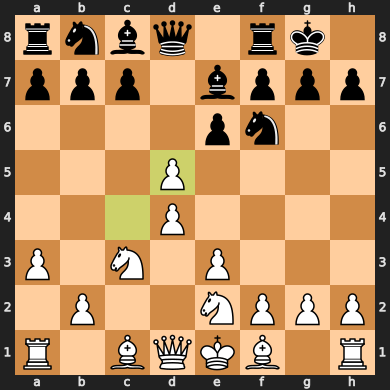

Pe6d5


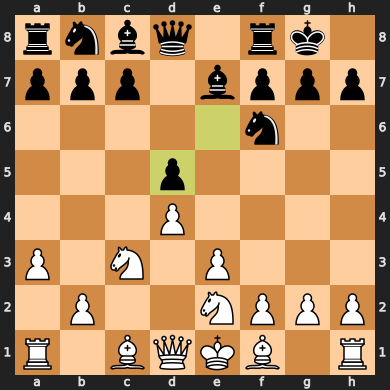

Ne2g3


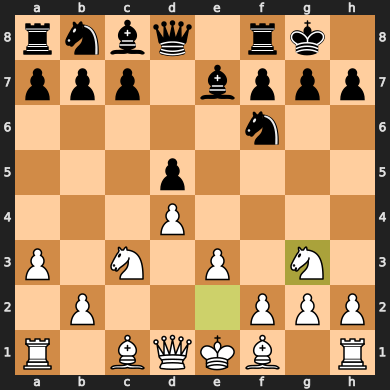

Pc7c6


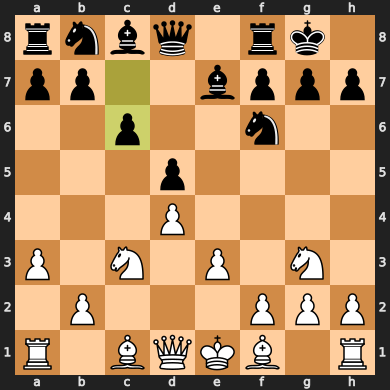

Bf1d3


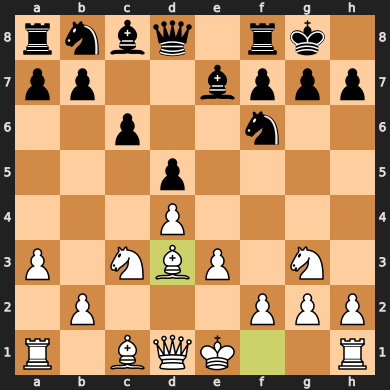

Rf8e8


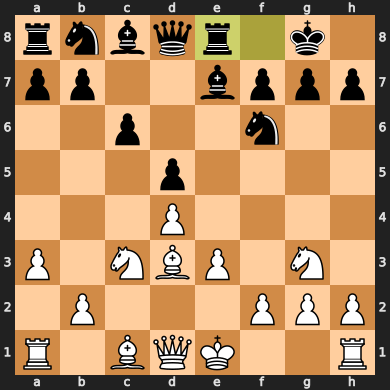

Ke1g1


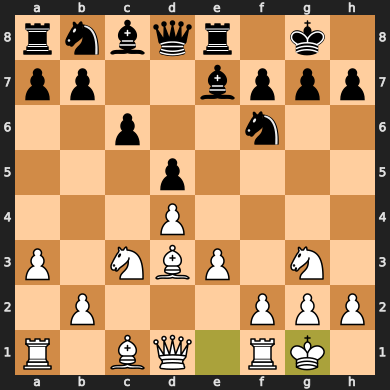

Nb8d7


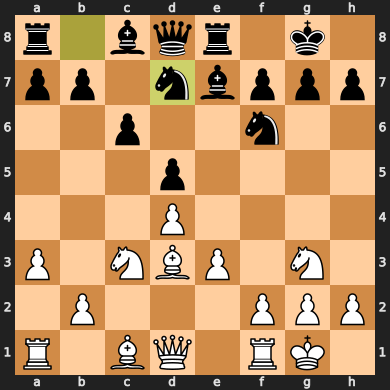

Pf2f3


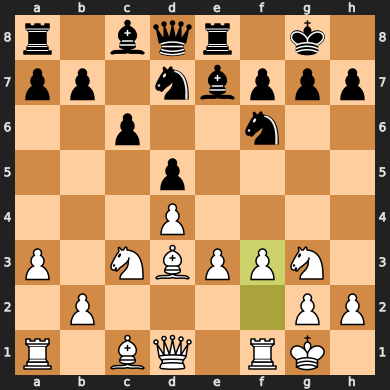

Nd7f8


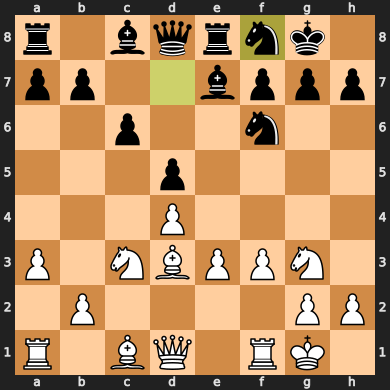

Pe3e4


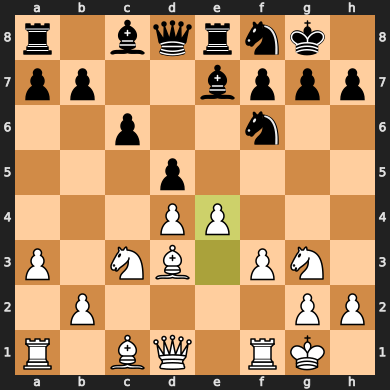

Pd5e4


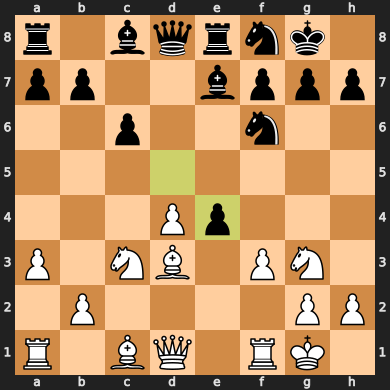

Pf3e4


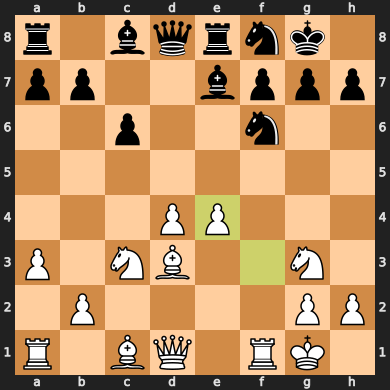

Bc8g4


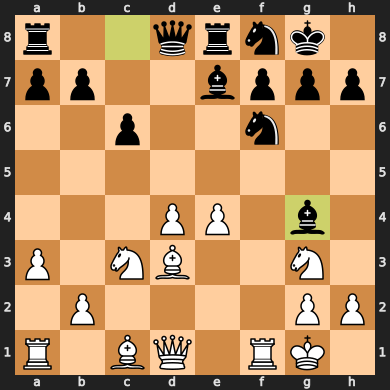

Bd3e2


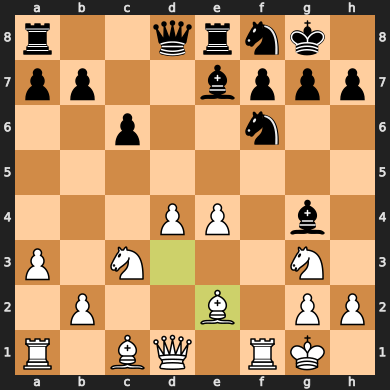

Bg4e2


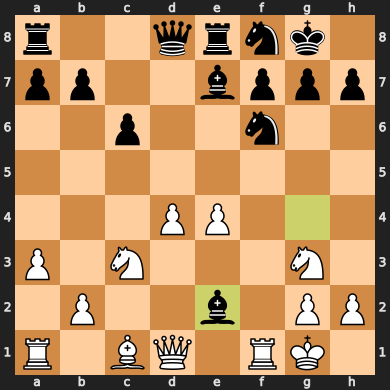

Qd1e2


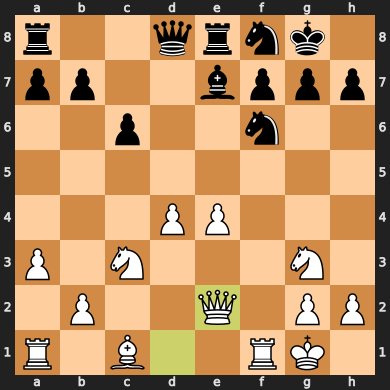

Nf8e6


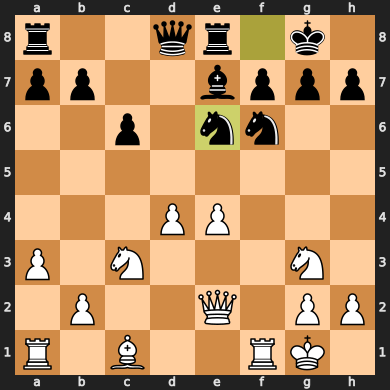

Bc1e3


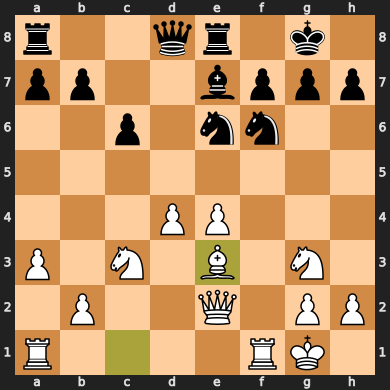

Ne6d4


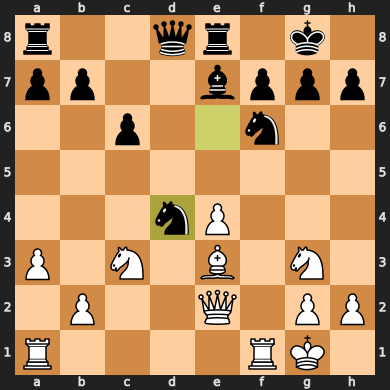

Be3d4


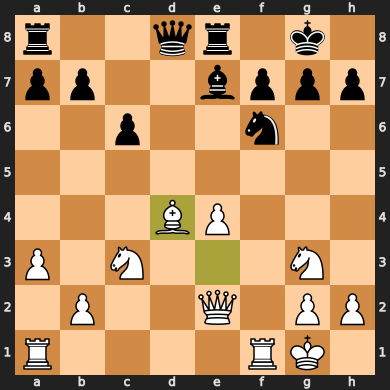

Qd8d4


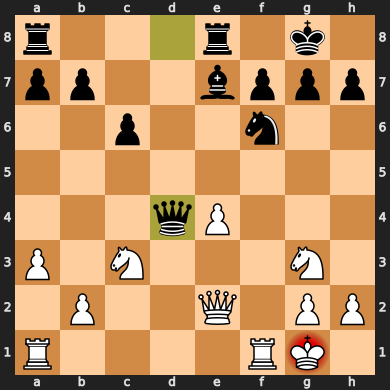

Kg1h1


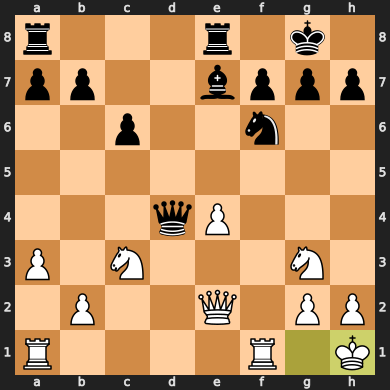

Ra8d8


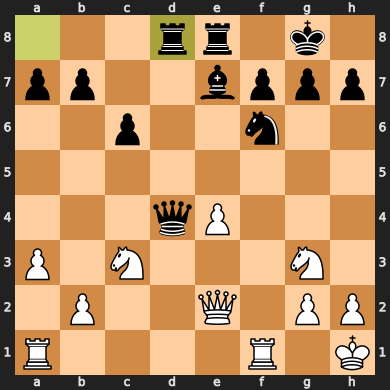

Ra1d1


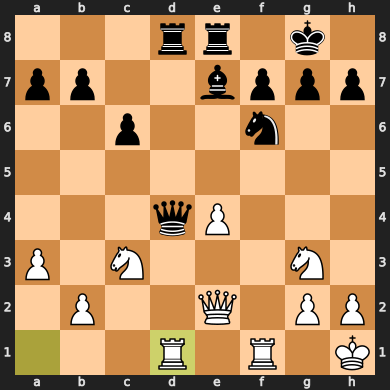

Qd4b6


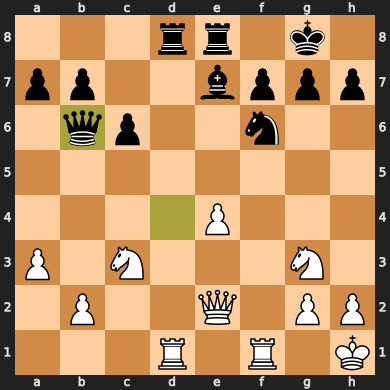

Pe4e5


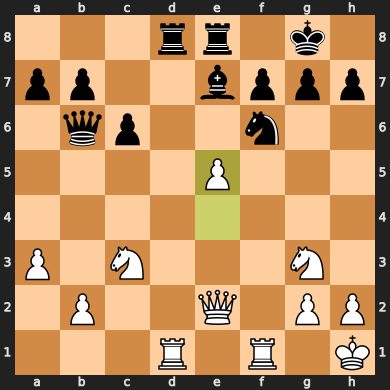

Nf6d5


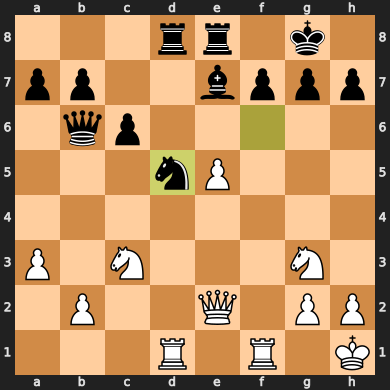

Nc3d5


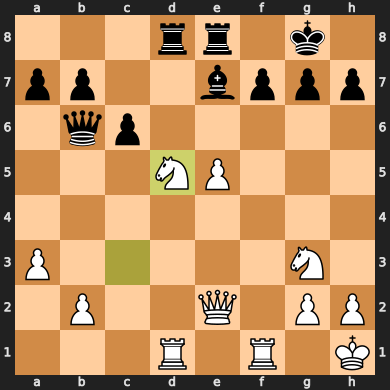

Pc6d5


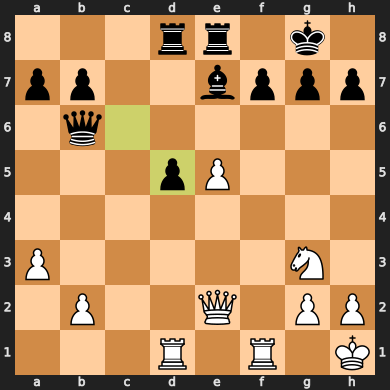

Ng3f5


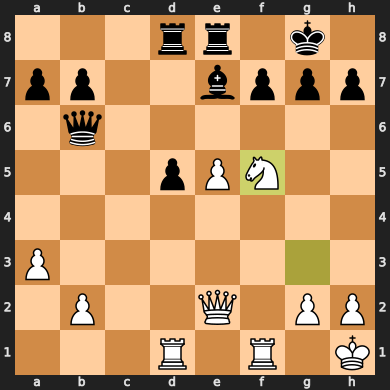

Be7f8


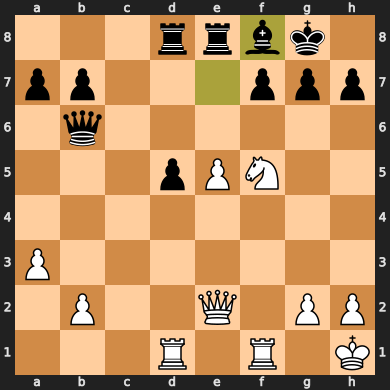

Qe2g4


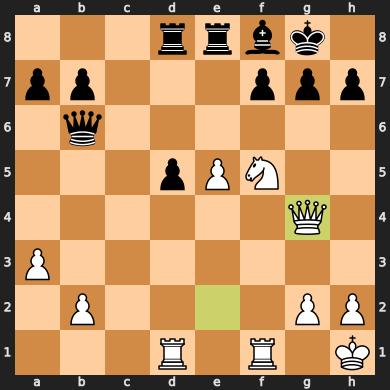

Qb6e6


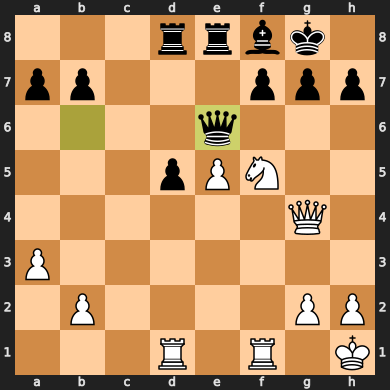

Nf5d4


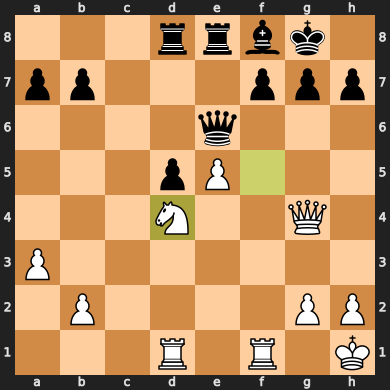

Qe6e5


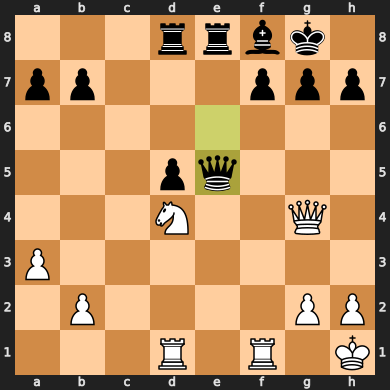

Nd4f3


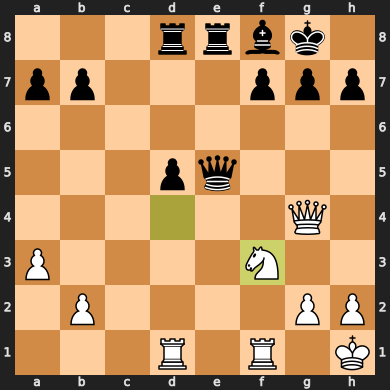

Qe5e4


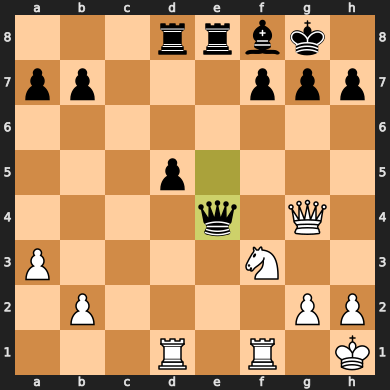

Qg4h5


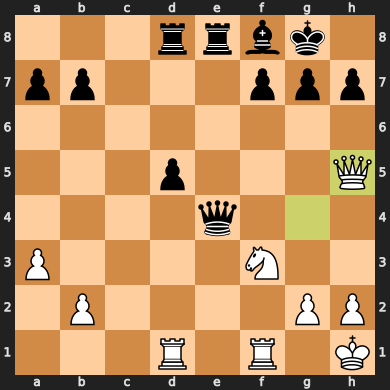

Pg7g6


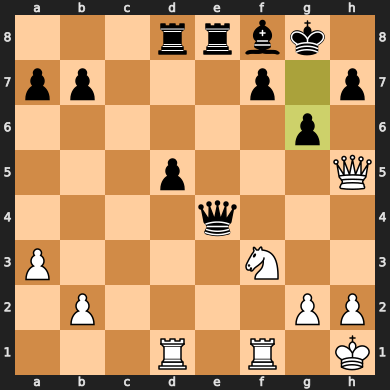

Qh5h6


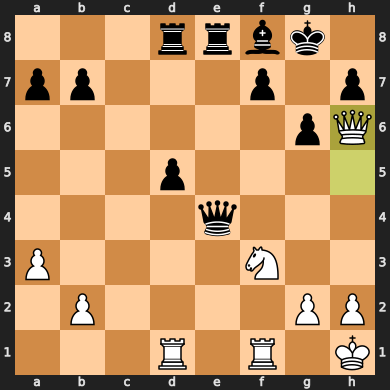

Bf8g7


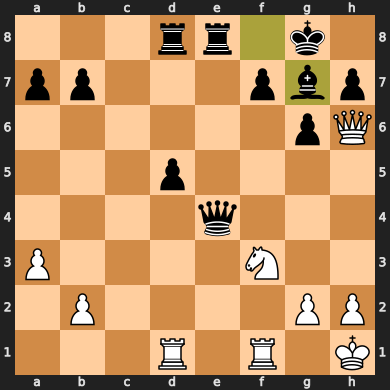

Qh6h4


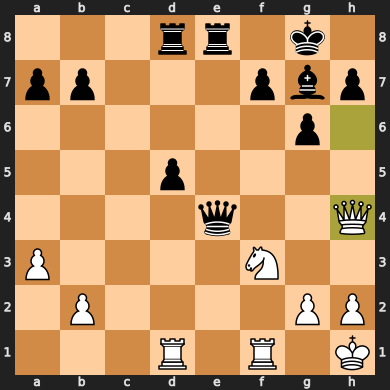

Qe4e6


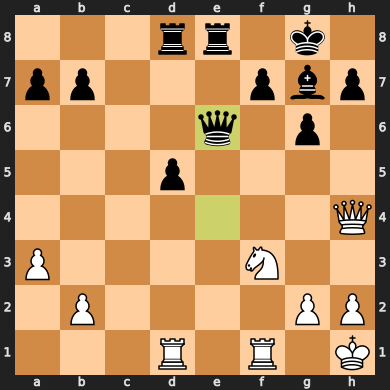

Nf3g5


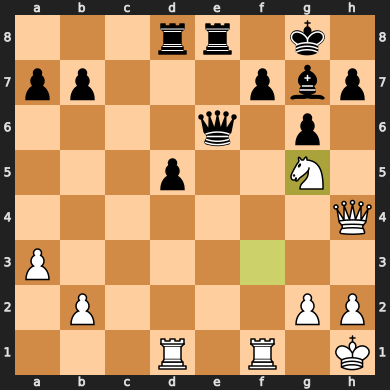

Qe6f6


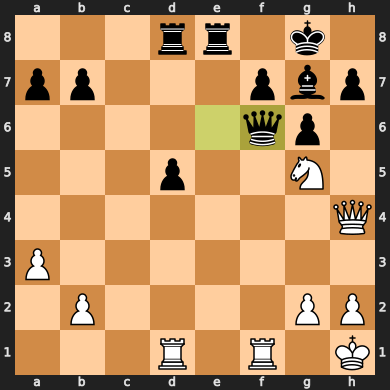

Rf1f6


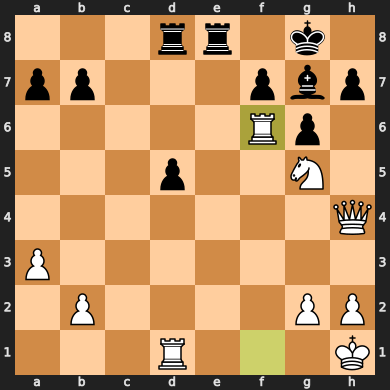

Bg7f6


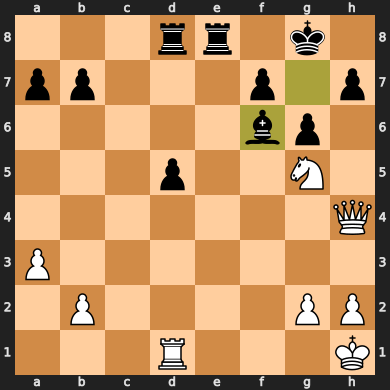

Qh4h7


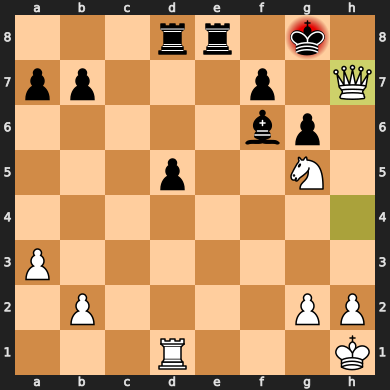

Kg8f8


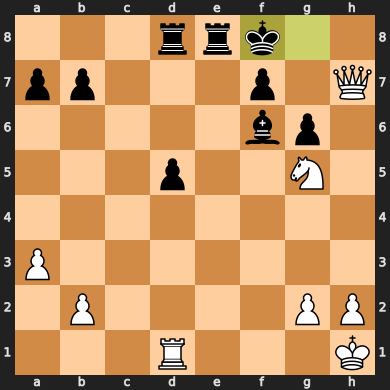

Rd1f1


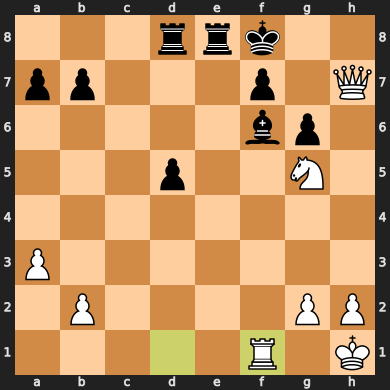

Kf8e7


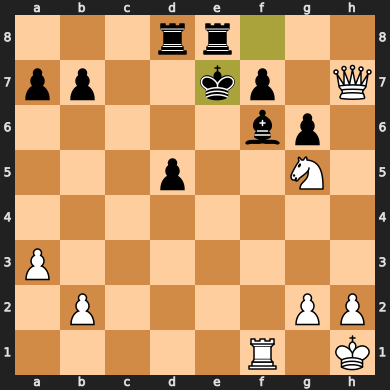

Qh7f7


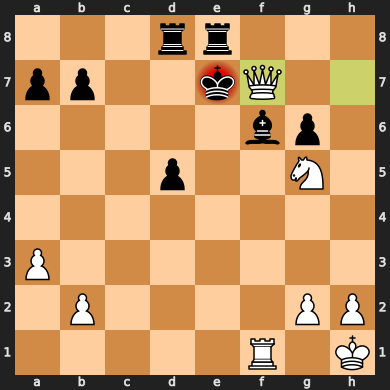

Ke7d6


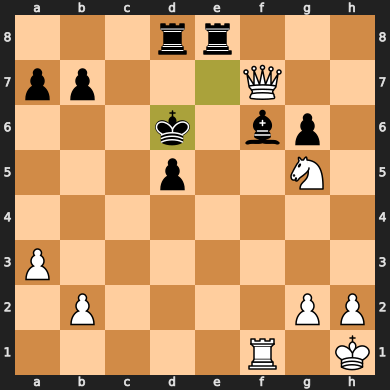

Qf7f6


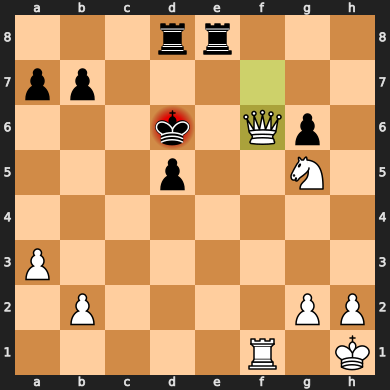

Kd6c7


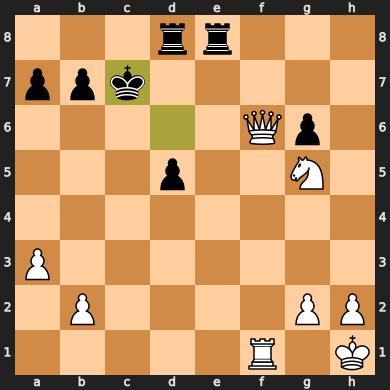

Qf6f7


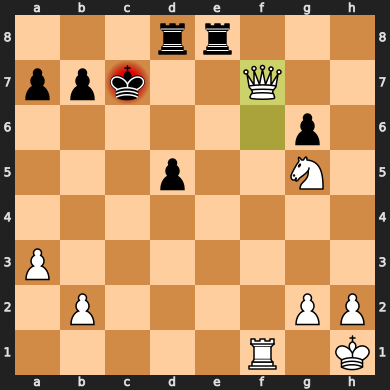

Kc7b6


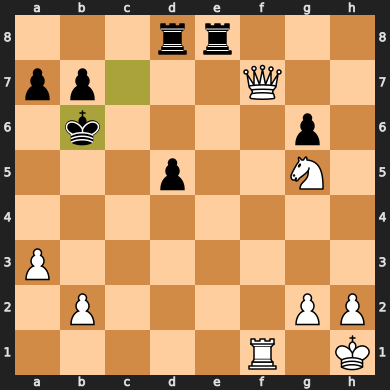

Qf7f6


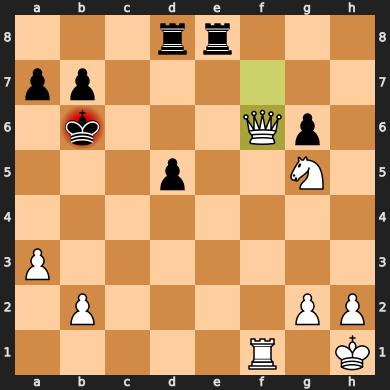

Rd8d7
1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. e3 O-O 5. Ne2 d5 6. a3 Be7 7. cxd5 exd5 8. Ng3 c6 9. Bd3 Re8 10. O-O Nbd7 11. f3 Nf8 12. e4 dxe4 13. fxe4 Bg4 14. Be2 Bxe2 15. Qxe2 Ne6 16. Be3 Nxd4 17. Bxd4 Qxd4+ 18. Kh1 Rad8 19. Rad1 Qb6 20. e5 Nd5 21. Nxd5 cxd5 22. Nf5 Bf8 23. Qg4 Qe6 24. Nd4 Qxe5 25. Nf3 Qe4 26. Qh5 g6 27. Qh6 Bg7 28. Qh4 Qe6 29. Ng5 Qf6 30. Rxf6 Bxf6 31. Qxh7+ Kf8 32. Rf1 Ke7 33. Qxf7+ Kd6 34. Qxf6+ Kc7 35. Qf7+ Kb6 36. Qf6+ *


In [75]:
import chess
import chess.pgn

def uci_to_pgn(uci_moves):
    board = chess.Board()

    moves = uci_moves.split()

    display(board)

    for move_str in moves:
        print(move_str)
        uci_move = move_str[1:]
        move = chess.Move.from_uci(uci_move)
        if board.is_legal(move) and chess.piece_symbol(board.piece_type_at(move.from_square)).upper() == move_str[0]:
            board.push_uci(uci_move)
        else:
            break
        display(board)

    game = chess.pgn.Game().from_board(board)
    game.headers.clear()

    return str(game)

# Test the function
print(uci_to_pgn(generated_game))